# Исходные данные


 **Признаки**
 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — сколько лет человек является клиентом банка
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата

**Целевой признак**
 - Exited — факт ухода клиента

# Задачи

 **Главная задача**
 - Спрогнозировать, уйдёт ли клиент из банка в ближайшее время. 
  - Построить модель с предельно большим значением F1-меры - 0.59 и выше. Дополнительно измерить AUC-ROC, сравнивая её значение с F1-мерой.

**Ход действий**

 - Обучить модель вначале без учёта дисбаланса классов, затем учитывая дисбаланс.

# Ход работы

## Обзор данных

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score 
from sklearn.utils import shuffle

In [2]:
# Открытие файла

try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
# Изучение файла

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# Изучение файла

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<div class="alert alert-block alert-warning">

    
Для последующей работы:
    
 - Необходима работа с пропусками в колонке Tenure
 - Приведение колонок к единому образцу
 - Устранение признаков, которые не важны для предсказания
 - Замена категориальных признаков для последующего обучения модели
 - Стандартизация для корректной работы логистической регрессии

## Общая предобработка 

*В колонке tenure (сколько лет человек является клиентом банка) есть пропуски - 9 штук. Заменим их медианой.*

In [5]:
data.groupby(by=['Geography', 'Gender', 'Age']).median()

RowNumber  CustomerId  CreditScore  Tenure     Balance  \
Geography Gender Age                                                           
France    Female 18      3118.0  15682704.5        625.5     NaN   90830.905   
                 19      4331.0  15666652.0        648.0     3.0       0.000   
                 20      6206.0  15746419.0        657.5     6.0   62133.430   
                 21      5770.5  15709515.5        622.5     7.0   98683.140   
                 22      3928.0  15672284.5        662.0     6.0   95189.275   
...                         ...         ...          ...     ...         ...   
Spain     Male   76      7671.0  15728122.5        593.5     5.5  127472.655   
                 77      2884.0  15688620.5        717.0     5.0   74541.850   
                 78      9737.0  15644103.0        659.0     2.0  151675.650   
                 80      3995.0  15763097.0        809.0     8.0       0.000   
                 88      2459.0  15813303.0        513.0    10.0       0.000   

                      NumOfProducts  HasCrCard  IsActiveMember  \
Geography Gender Age                                             
France    Female 18             1.0        1.0             0.5   
                 19             2.0        1.0             1.0   
                 20             1.0        0.0             0.5   
                 21             2.0        1.0             1.0   
                 22             1.5        1.0             1.0   
...                             ...        ...             ...   
Spain     Male   76             1.5        1.0             1.0   
                 77             1.0        1.0             1.0   
                 78             1.0        0.0             1.0   
                 80             2.0        0.0             1.0   
                 88             2.0        1.0             1.0   

                      EstimatedSalary  Exited  
Geography Gender Age                           
France    Female 18         40704.150     0.0  
                 19        122823.340     0.0  
                 20         68120.360     0.0  
                 21         97061.425     0.0  
                 22         92792.365     0.0  
...                               ...     ...  
Spain     Male   76        110754.175     0.0  
                 77        112424.875     0.0  
                 78         49978.670     0.0  
                 80         34164.050     0.0  
                 88         52952.240     0.0  

[374 rows x 10 columns]

In [6]:
for country in data['Geography'].unique():
    data.loc[(data['Geography']==country)&(data['Tenure'].isna()), 'Tenure'] =\
    data.loc[data['Geography']==country, 'Tenure'].median()
    
data.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
# Единый формат написания

data.columns = data.columns.str.lower()

data = data.rename(columns = {'customerid':'customer_id',
                              'numofproducts':'num_of_products',
                              'hascrcard':'has_cr_card',
                              'isactivemember':'is_active_member',
                              'estimatedsalary':'estimated_salary'
                             })

data.columns

Index(['rownumber', 'customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

# Обучение модели

## Предобработка к обучению

*Колонка с фамилией с очень маленькой вероятностью будет оказывать существенное влияние на прогноз. Кроме того, в датасете есть колонка с уникальным индентирикатором клиента*

In [8]:
# Удаление колонки surname

data = data.drop(['surname'], axis=1)

# Удаление колонки rownumber

data = data.drop(['rownumber'], axis=1)

# Удаление колонки customer_id 

data = data.drop(['customer_id'], axis=1)

data.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

*Колонки с категориальными признаками - geography и gender*

*Используем технику прямого кодирования OHE*

In [9]:
# Работа с категориальными переменными

data = pd.get_dummies(data, drop_first=True)

data.head()

,creditscore,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


**Теперь можно приступать к обучению модели**

## Подготовка 

In [10]:
# Разделим датасет по признакам и целевому признаку

# Признаки для прогноза - Х
X = data.drop(['exited'], axis=1)

# Целевой признак у
y = data['exited']

In [11]:
# Разделим датасеты на тренировочную, валидационную и тестовую выборки как 3:1:1
# Сначала на тестовую и общую, а затем общую на валидационную и тестовую

X_train, X_common, y_train, y_common = train_test_split(X, y, train_size=0.6, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_common, y_common, test_size=0.5, random_state=123)

# Проверим размерность полученных выборок

print('train', X_train.shape)
print('valid', X_valid.shape)
print('test', X_test.shape)

train (6000, 11)
valid (2000, 11)
test (2000, 11)


In [12]:
# Стандартизируем данные

scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

## Поиск лучшей модели 

### LogisticRegression

In [13]:
# подберем алгоритм и оптимальное кол-во итераций

algorithm = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

best_algorithm = None
best_iteration = 0
best_f1 = 0
best_auc_roc = 0

for a in algorithm:
    for iteration in range(100,1000,50):
        lr = LogisticRegression(solver=a, random_state=123, max_iter=iteration)
        lr.fit(X_train, y_train)
        y_predicted = lr.predict(X_valid)
        proba_1 = lr.predict_proba(X_valid)[:,1]
    
        f1 = f1_score(y_valid, y_predicted)
        auc_roc = roc_auc_score(y_valid, proba_1)
        
        if (f1 > best_f1) and (auc_roc > best_auc_roc):
            best_f1 = f1
            best_auc_roc = auc_roc
            best_algorithm = a
            best_iteration = iteration
        
print('Solver:', a, 
      'iteration:', best_iteration, 
      'f1:', best_f1, 
      'Auc_roc:', best_auc_roc)

Solver: saga iteration: 100 f1: 0.28190476190476194 Auc_roc: 0.7470289080921164


<div class="alert alert-block alert-warning">


Логистическая регрессия выдала максимальные показатели при алгоритме saga и глубине 100:
 - f1 = 0.28
 - auc_roc = 0.747

### DecisionTreeClassifier

In [14]:
# выберем оптимальное кол-во деревьев и оптимальную функцию

criterion = ['gini', 'entropy']

best_criterion = None
best_depth = 0
best_f1 = 0
best_auc_roc = 0

for c in criterion:
    for depth in range(1,10,5):
        dtc = DecisionTreeClassifier(criterion=c, max_depth=depth, random_state=123)
        dtc.fit(X_train, y_train)
        y_predicted = dtc.predict(X_valid)
        proba_1 = dtc.predict_proba(X_valid)[:,1]
    
        f1 = f1_score(y_valid, y_predicted)
        auc_roc = roc_auc_score(y_valid, proba_1)
    
        if (f1 > best_f1) and (auc_roc > best_auc_roc):
            best_f1 = f1
            best_auc_roc = auc_roc
            best_criterion = c
            best_depth = depth

print('criterion', best_criterion, 
      'depth', best_depth, 
      'f1', best_f1, 
      'auc_roc', best_auc_roc)    

criterion entropy depth 6 f1 0.5723076923076923 auc_roc 0.8432440846824408


<div class="alert alert-block alert-warning">


Дерево решений выдало максимальные показатели при глубине 6 и функции entropy:
 - f1 = 0.57
 - auc_roc = 0.84

### RandomForestClassifier 

In [15]:
# выберем оптимальное кол-во деревьев и оптимальную глубину 

best_est = 0
best_depth = 0
best_f1 = 0
best_auc_roc = 0

for n in range(100,500,50):
    for depth in range(10,100,20):
        rfc = RandomForestClassifier(n_estimators=n, random_state=123, criterion='entropy', max_depth=depth)
        rfc.fit(X_train, y_train)
        y_predicted = rfc.predict(X_valid)
        proba_1 = rfc.predict_proba(X_valid)[:,1]
    
        f1 = f1_score(y_valid, y_predicted)
        auc_roc = roc_auc_score(y_valid, proba_1)
    
        if (f1 > best_f1) and (auc_roc > best_auc_roc):
            best_f1 = f1
            best_auc_roc = auc_roc
            best_est = n
            best_depth = depth

print('n_estimators', best_est, 
      'depth', best_depth,
      'f1', best_f1, 
      'auc_roc', best_auc_roc)    

n_estimators 450 depth 10 f1 0.576923076923077 auc_roc 0.8696196370210694


<div class="alert alert-block alert-warning">

Случайный лес выдал максимальные показатели при кол-ве деревьев 450 и глубине 10:
 - f1 = 0.57
 - auc_rc = 0.86

**Вывод**

Самый лучший результат показала модель Случайного леса - ее будем ипользовать в дальнейшем и попробуем улучшить показатели

# Дисбаланс классов

<AxesSubplot:title={'center':'Доля оставшихся и ушедших клиентов'}>

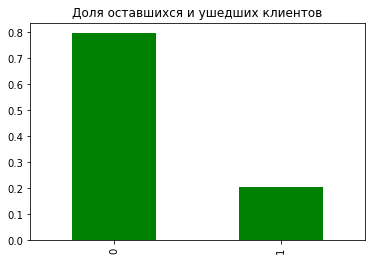

In [16]:
# Оценим дисбаланс классов

y.value_counts(normalize=True).plot(kind='bar', 
                                    title='Доля оставшихся и ушедших клиентов',
                                    color='green',
                                   )

Почти 80% клиентов осталось и 20% ушло. Дисбаланс достаточно большой - стоит обработать данные для лучшего обучения модели.

## Автоматический баланс классов

Попробуем метод 'самообучения' модели, задав параметр class_weight=balanced 

### LogisticRegression

In [17]:
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [18]:
# подберем алгоритм и оптимальное кол-во итераций при балансировании классов

algorithm = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

best_algorithm = None
best_iteration = 0
best_f1 = 0
best_auc_roc = 0

for a in algorithm:
    for iteration in range(100,1000,50):
        lr = LogisticRegression(solver=a, random_state=123, max_iter=iteration, class_weight='balanced')
        lr.fit(X_train, y_train)
        y_predicted = lr.predict(X_valid)
        proba_1 = lr.predict_proba(X_valid)[:,1]
    
        f1 = f1_score(y_valid, y_predicted)
        auc_roc = roc_auc_score(y_valid, proba_1)
        
        if (f1 > best_f1) and (auc_roc > best_auc_roc):
            best_f1 = f1
            best_auc_roc = auc_roc
            best_algorithm = a
            best_iteration = iteration
        
print('Solver:', a, 
      'iteration:', best_iteration, 
      'f1:', best_f1, 
      'Auc_roc:', best_auc_roc)

Solver: saga iteration: 100 f1: 0.456140350877193 Auc_roc: 0.7494689963398677


<div class="alert alert-block alert-warning">

По сравнению с предыдущим обучением Логистической регрессии её показатели изменились:
 - f1-мера выросла с 0.28 до 0.45, 
 - auc_roc почти не изменилась и осталась на уровне 0.74.

### DecisionTreeClassifier

In [19]:
# выберем оптимальное кол-во деревьев и оптимальную функцию при балансировании классов

criterion = ['gini', 'entropy']

best_criterion = None
best_depth = 0
best_f1 = 0
best_auc_roc = 0

for c in criterion:
    for depth in range(1,10,5):
        dtc = DecisionTreeClassifier(criterion=c, max_depth=depth, random_state=123, class_weight='balanced')
        dtc.fit(X_train, y_train)
        y_predicted = dtc.predict(X_valid)
        proba_1 = dtc.predict_proba(X_valid)[:,1]
    
        f1 = f1_score(y_valid, y_predicted)
        auc_roc = roc_auc_score(y_valid, proba_1)
    
        if (f1 > best_f1) and (auc_roc > best_auc_roc):
            best_f1 = f1
            best_auc_roc = auc_roc
            best_criterion = c
            best_depth = depth

print('criterion', best_criterion, 
      'depth', best_depth, 
      'f1', best_f1, 
      'auc_roc', best_auc_roc)   

criterion gini depth 6 f1 0.5606617647058824 auc_roc 0.8365528064175586


<div class="alert alert-block alert-warning">

Показетели Дерева решений при балансировании классов изменились:
 - f1 уменьшилась с 0.57 до 0.56, 
 - auc_roc уменьшилась с 0.84 до 0.83

### RandomForestClassifier  

In [20]:
# выберем оптимальное кол-во деревьев и оптимальную глубину при балансировании классов

best_est = 0
best_depth = 0
best_f1 = 0
best_auc_roc = 0

for n in range(100,500,50):
    for depth in range(10,100,20):
        rfc = RandomForestClassifier(n_estimators=n, random_state=123, criterion='entropy', max_depth=depth, class_weight='balanced')
        rfc.fit(X_train, y_train)
        y_predicted = rfc.predict(X_valid)
        proba_1 = rfc.predict_proba(X_valid)[:,1]
    
        f1 = f1_score(y_valid, y_predicted)
        auc_roc = roc_auc_score(y_valid, proba_1)
    
        if (f1 > best_f1) and (auc_roc > best_auc_roc):
            best_f1 = f1
            best_auc_roc = auc_roc
            best_est = n
            best_depth = depth

print('n_estimators', best_est, 
      'depth', best_depth,
      'f1', best_f1, 
      'auc_roc', best_auc_roc)    

n_estimators 100 depth 10 f1 0.6308068459657702 auc_roc 0.8654869746066465


<div class="alert alert-block alert-warning">

Показатели Случайного леса изменились:
 - f1 увеличилась с 0.57 до 0.63
 - auc_rc практически не изменилось (0.86)

## Downsampling 

Применим метод downsampling и сделаем соотношение классов близким к 1:1

In [21]:
X_train, X_common, y_train, y_common = train_test_split(X, y, train_size=0.6, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_common, y_common, test_size=0.5, random_state=123)

In [22]:
# Применим метод только у обучающей выборке

X_zero = X_train[y_train==0]
X_one = X_train[y_train==1]
y_zero = y_train[y_train==0]
y_one = y_train[y_train==1]

X_train = pd.concat([X_zero.sample(frac=0.25, random_state=123)] + [X_one])
y_train = pd.concat([y_zero.sample(frac=0.25, random_state=123)] + [y_one])
    
X_train, y_train = shuffle(X_train, y_train, random_state=123)

<AxesSubplot:title={'center':'Доля оставшихся и ушедших клиентов'}>

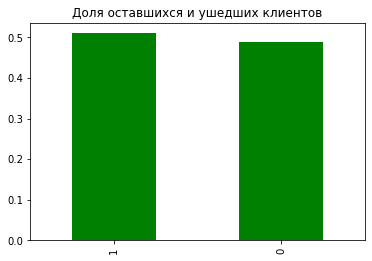

In [23]:
# Оценим полученный дисбаланс классов

y_train.value_counts(normalize=True).plot(kind='bar', 
                                    title='Доля оставшихся и ушедших клиентов',
                                    color='green',
                                   )

### LogisticRegression

In [24]:
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [25]:
# подберем алгоритм и оптимальное кол-во итераций

algorithm = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

best_algorithm = None
best_iteration = 0
best_f1 = 0
best_auc_roc = 0

for a in algorithm:
    for iteration in range(100,1000,50):
        lr = LogisticRegression(solver=a, random_state=123, max_iter=iteration)
        lr.fit(X_train, y_train)
        y_predicted = lr.predict(X_valid)
        proba_1 = lr.predict_proba(X_valid)[:,1]
    
        f1 = f1_score(y_valid, y_predicted)
        auc_roc = roc_auc_score(y_valid, proba_1)
        
        if (f1 > best_f1) and (auc_roc > best_auc_roc):
            best_f1 = f1
            best_auc_roc = auc_roc
            best_algorithm = a
            best_iteration = iteration
        
print('Solver:', a, 
      'iteration:', best_iteration, 
      'f1:', best_f1, 
      'Auc_roc:', best_auc_roc)

Solver: saga iteration: 100 f1: 0.4548551959114139 Auc_roc: 0.7476768589869209


<div class="alert alert-block alert-warning">

 - f1-мера с 0.28 увеличилась до 0.45 при автоматической балансировке, и не изменилась при методе downsampling
 - auc_roc не изменилась и осталась на уровне 0.74 во всех методах

### DecisionTreeClassifier

In [26]:
# выберем оптимальное кол-во деревьев и оптимальную функцию

criterion = ['gini', 'entropy']

best_criterion = None
best_depth = 0
best_f1 = 0
best_auc_roc = 0

for c in criterion:
    for depth in range(1,10,5):
        dtc = DecisionTreeClassifier(criterion=c, max_depth=depth, random_state=123)
        dtc.fit(X_train, y_train)
        y_predicted = dtc.predict(X_valid)
        proba_1 = dtc.predict_proba(X_valid)[:,1]
    
        f1 = f1_score(y_valid, y_predicted)
        auc_roc = roc_auc_score(y_valid, proba_1)
    
        if (f1 > best_f1) and (auc_roc > best_auc_roc):
            best_f1 = f1
            best_auc_roc = auc_roc
            best_criterion = c
            best_depth = depth

print('criterion', best_criterion, 
      'depth', best_depth, 
      'f1', best_f1, 
      'auc_roc', best_auc_roc)    

criterion gini depth 6 f1 0.5666356011183598 auc_roc 0.838955756016461


<div class="alert alert-block alert-warning">

 - f1-мера с  0.57 уменьшилась до 0.56 при автоматической балансировке, и осталась на уровне 0.56 при методе downsampling
 - auc_roc уменьшилась с 0.84 до 0.83 при автоматической балансировке, и осталась на уровне до 0.83 при методе downsampling

### RandomForestClassifier 

In [27]:
# выберем оптимальное кол-во деревьев, глубину и функцию

criterion = ['gini', 'entropy']

best_criterion = None
best_est = 0
best_depth = 0
best_f1 = 0
best_auc_roc = 0

for c in criterion:
    for n in range(100,500,50):
        for depth in range(5,50,5):
            rfc = RandomForestClassifier(n_estimators=n, random_state=123, criterion=c, max_depth=depth)
            rfc.fit(X_train, y_train)
            y_predicted = rfc.predict(X_valid)
            proba_1 = rfc.predict_proba(X_valid)[:,1]
    
            f1 = f1_score(y_valid, y_predicted)
            auc_roc = roc_auc_score(y_valid, proba_1)
    
            if (f1 > best_f1) and (auc_roc > best_auc_roc):
                best_f1 = f1
                best_auc_roc = auc_roc
                best_criterion = c
                best_est = n
                best_depth = depth

print('criterion', best_criterion,
      'n_estimators', best_est, 
      'depth', best_depth,
      'f1', best_f1, 
      'auc_roc', best_auc_roc)    

criterion entropy n_estimators 200 depth 10 f1 0.6005719733079123 auc_roc 0.8705741793148788


<div class="alert alert-block alert-warning">

 - f1-мера увеличилась с 0.57 до 0.63 при автоматической балансировке, и немного уменьшилась до 0.60 при методе downsampling
 - auc_roc практически не изменилось при автоматической балансировке (0.86), и увеличилась до 0.87 при методе downsampling


#  Итог

Выведем алгоритм лучшего обучения - Случайный лес с окол-вом деревьев 200, глубиной 10, функцией entropy и использованием метода downsampling

In [28]:
X = data.drop(['exited'], axis=1)
y = data['exited']

In [29]:
X_train, X_common, y_train, y_common = train_test_split(X, y, train_size=0.6, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_common, y_common, test_size=0.5, random_state=123)

In [30]:
X_zero = X_train[y_train==0]
X_one = X_train[y_train==1]
y_zero = y_train[y_train==0]
y_one = y_train[y_train==1]

X_train = pd.concat([X_zero.sample(frac=0.25, random_state=123)] + [X_one])
y_train = pd.concat([y_zero.sample(frac=0.25, random_state=123)] + [y_one])
    
X_train, y_train = shuffle(X_train, y_train, random_state=123)

In [31]:
# обучим модель на новых данных

rfc = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=123, criterion='entropy')
rfc.fit(X_train, y_train)
predicted_valid = rfc.predict(X_valid)
proba_1 = rfc.predict_proba(X_valid)[:,1]

f1 = f1_score(y_valid, predicted_valid)
auc_roc = roc_auc_score(y_valid, proba_1)

print(f1, auc_roc)

0.6000000000000001 0.8705741793148787


In [32]:
# проведем финальную проверку на старой (не измененной) тестовой выборке

predicted_test = rfc.predict(X_test)
proba_1_test = rfc.predict_proba(X_test)[:,1]

f1 = f1_score(y_test, predicted_test)
auc_roc = roc_auc_score(y_test, proba_1_test)

print('F1:', f1, 'AUC-ROC:', auc_roc)

F1: 0.6080305927342257 AUC-ROC: 0.868448968957046


Тестовая выборка показала результаты F1 60% и  AUC-ROC в 86%, практически не отличаясь от показателей валидайионной выборки.
Модель удачно обучена

# Итоги проекта

<div class="alert alert-block alert-warning">


- Лучший результат показала модель Случайного леса и с использованием downsampling как метода борьбы с дисбалансом классов, влияющих на качество обучения (переобучение модели). 

Итоговые показатели моделей с лучшими гиперпараметрами менялись при обычном обучении, автоматической балансировке модели и методе downsampling:

- Логистическая регрессия:
   - f1-мера - 0.28 - 0.45 - 0.45
   - auc_roc - 0.74 - 0.74 - 0.74 

- Дерево решений:
    - f1-мера - 0.57 - 0.56 - 0.56 
    - auc_roc - 0.84 - 0.83 - 0.83

- Случайный лес:
    - f1-мера - 0.57 - 0.63 - 0.60 
    - auc_roc - 0.86 - 0.86 - 0.87
    
Наиболее сильные колебания показателей наблюдаются у логистической регрессии, самые стабильные результаты показывал Случайный лес   